# **ML LAB Part 1**

**By Weihang Li, Niklas Klein and Nicolas Junghanns** 




# 1: Loading the Data, Preprocessing, Initial Data Analysis

     Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
0          2       3  12669   9656     7561     214              2674   
1          2       3   7057   9810     9568    1762              3293   
2          2       3   6353   8808     7684    2405              3516   
3          1       3  13265   1196     4221    6404               507   
4          2       3  22615   5410     7198    3915              1777   
..       ...     ...    ...    ...      ...     ...               ...   
435        1       3  29703  12051    16027   13135               182   
436        1       3  39228   1431      764    4510                93   
437        2       3  14531  15488    30243     437             14841   
438        1       3  10290   1981     2232    1038               168   
439        1       3   2787   1698     2510      65               477   

     Delicassen  
0          1338  
1          1776  
2          7844  
3          1788  
4          5185  
..          ...

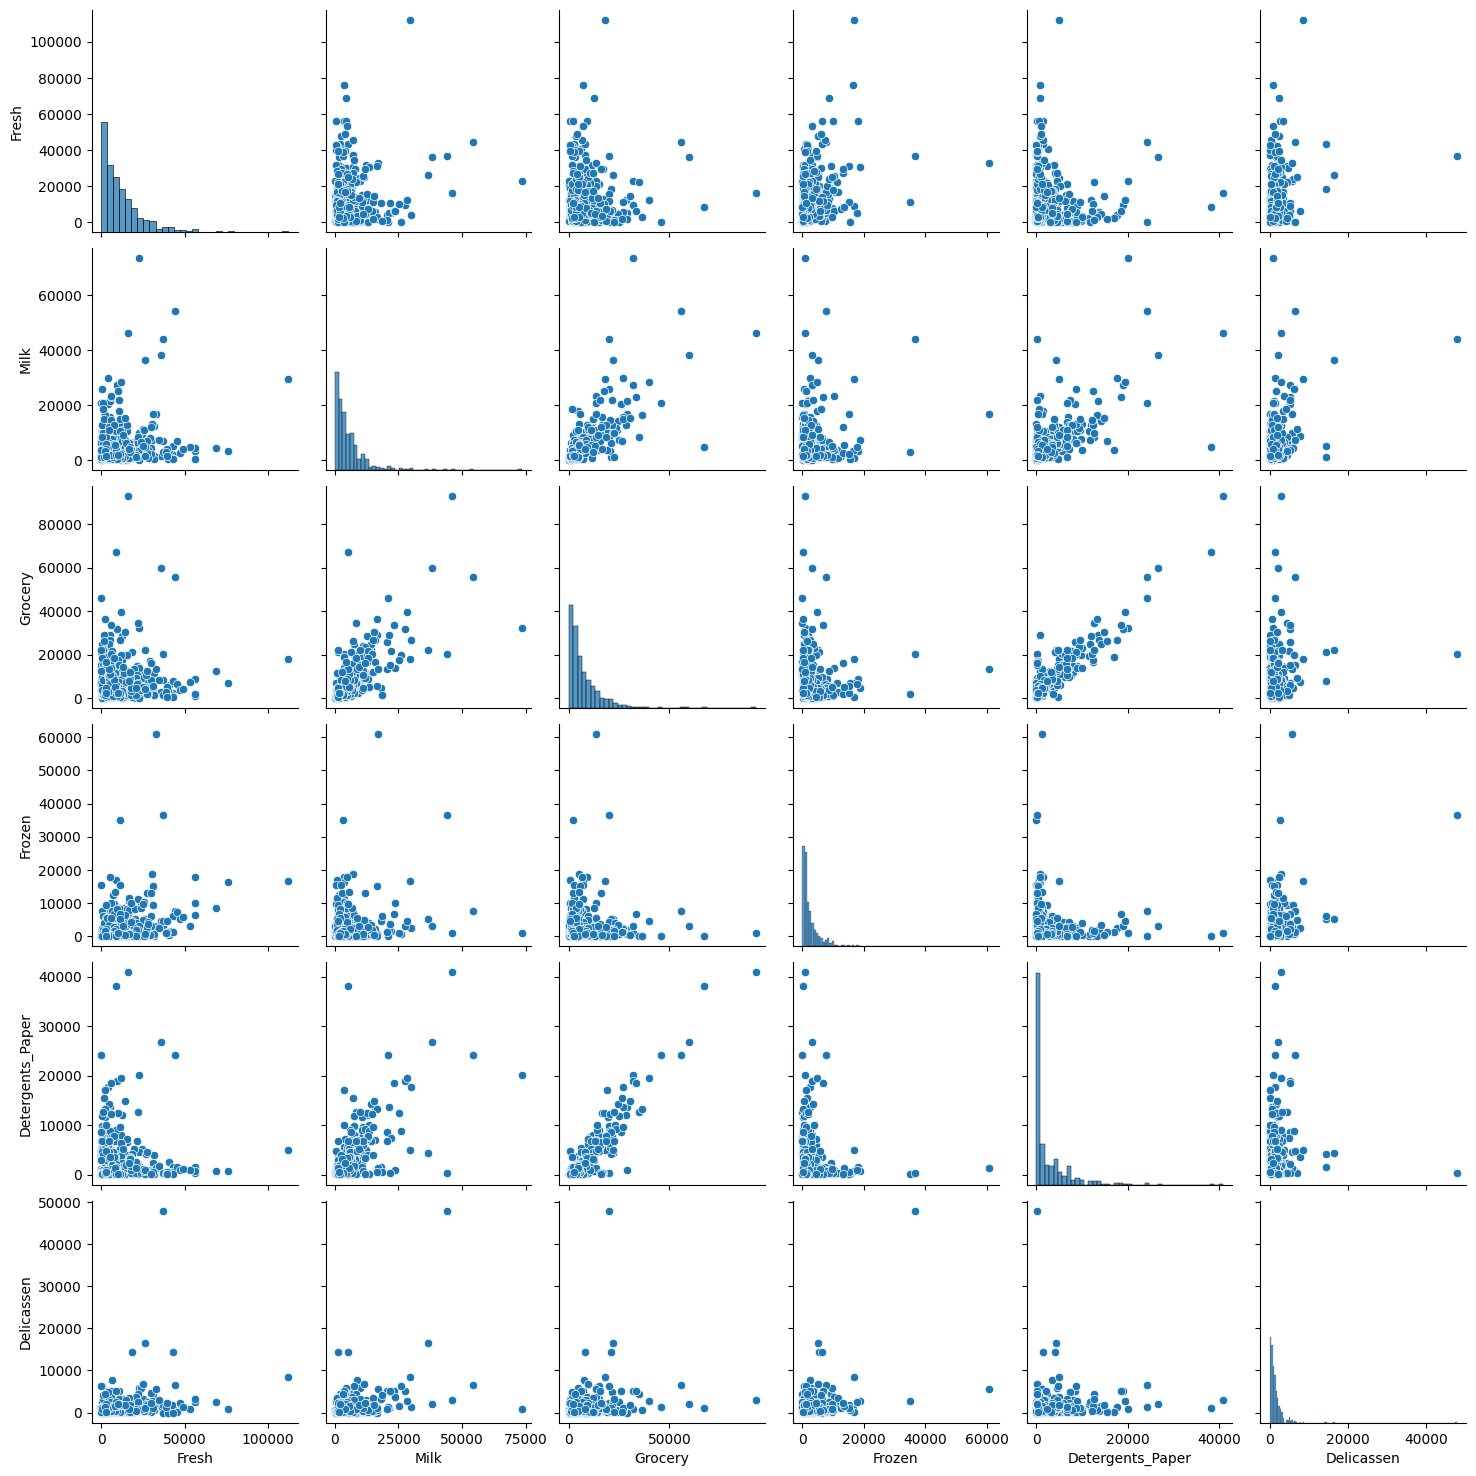

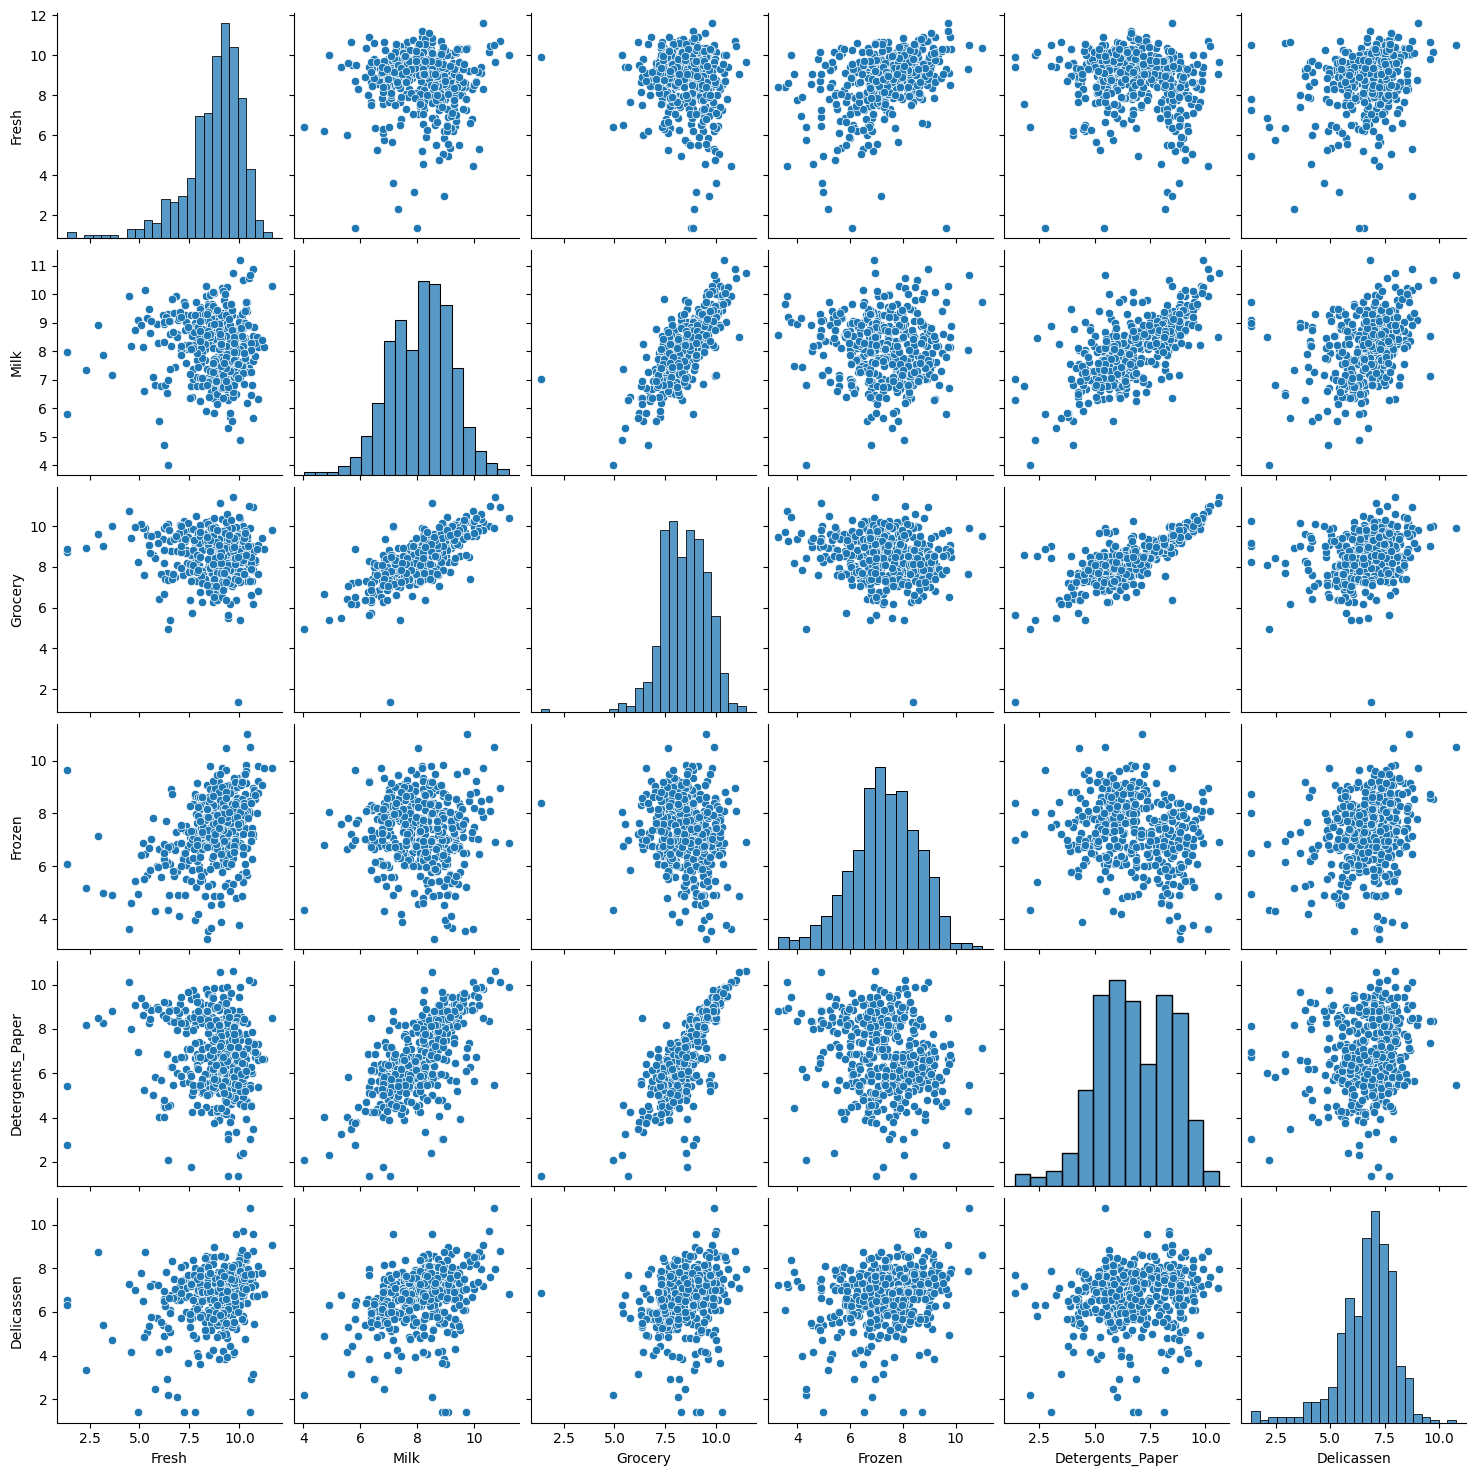

                     Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
Fresh             1.000000 -0.021096 -0.132989  0.386258         -0.158706   
Milk             -0.021096  1.000000  0.761128 -0.055229          0.678725   
Grocery          -0.132989  0.761128  1.000000 -0.164525          0.797141   
Frozen            0.386258 -0.055229 -0.164525  1.000000         -0.212771   
Detergents_Paper -0.158706  0.678725  0.797141 -0.212771          1.000000   
Delicassen        0.256442  0.342310  0.239998  0.256318          0.167573   

                  Delicassen  
Fresh               0.256442  
Milk                0.342310  
Grocery             0.239998  
Frozen              0.256318  
Detergents_Paper    0.167573  
Delicassen          1.000000  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import cupy as cp
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df = pd.read_csv(url)
print(df)

# Drop columns Channel + Region
df = df.drop(columns=['Channel', 'Region'])

# Apply log transformation
df_log = np.log1p(df)

# Plot histograms and scatter plots
print(df_log.head())
sns.pairplot(df)
plt.show()
sns.pairplot(df_log)
plt.show()

correlation_matrix = df_log.corr(method='pearson')
print(correlation_matrix)

# 2: Detecting Anomalies

We use bootstrapping to generate multiple subsets of the dataset and calculate anomaly scores for each subset using a softmin function controlled by a gamma parameter. Our idea is to iterate over a range of gamma values, seeking to maximize the mean variance and minimize the overall variance of anomaly scores. The optimal gamma is chosen as the one that minimizes the variance of variances across all bootstrap samples. Using this optimal gamma, the final anomaly scores are calculated and the top 10 anomalies, those with the highest scores, are identified. The process is accelerated by using GPU computation via the CuPy library.

datamatrix: 
 [[ 9.44699227  9.17543832  8.93089098  5.37063803  7.89170466  7.19967835]
 [ 8.861917    9.19125948  9.16628399  7.47477218  8.09985791  7.48268183]
 [ 8.75683981  9.08352921  8.94702566  7.7857209   8.16536363  8.96763167]
 ...
 [ 9.58410839  9.64788537 10.3170531   6.08221891  9.60521628  7.53262362]
 [ 9.23902501  7.59186171  7.71110125  6.94601399  5.12989871  7.66199756]
 [ 7.93307977  7.43779512  7.82843636  4.18965474  6.16961073  3.97029191]] 

gamma values:  [ 0.1         0.11908637  0.14181564  0.16888311  0.20111677  0.23950266
  0.28521503  0.33965224  0.40447953  0.48168001  0.57361525  0.6830976
  0.81347616  0.96873925  1.15363644  1.3738238   1.63603693  1.94829705
  2.32015629  2.76298998  3.29034456  3.91835201  4.66622329  5.55683609
  6.61743456  7.88046282  9.38455736 11.175729   13.30877035 15.84893192]


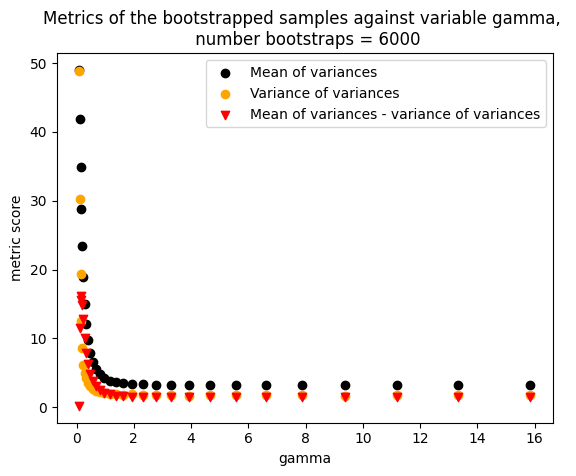

[ 66 285 439 203 184 402 161 228  65 218 109 204 183 128 187  95 142 154
  75 338]
             0          1          2          3          4          5
66    2.302585   7.336286   8.911665   5.170484   8.151622   3.332205
285  10.602989   6.463029   8.188967   6.949856   6.079933   2.944439
439   7.933080   7.437795   7.828436   4.189655   6.169611   3.970292
203   6.369901   6.530878   7.703910   6.152733   6.861711   2.944439
184   5.793014   6.823286   8.457655   4.317488   5.814131   2.484907
402  10.186408   8.466742   8.535426   5.398163   2.397895   5.831882
161   9.428270   6.293419   5.648974   6.996681   1.386294   7.711549
228   7.533694   6.359574   6.350886   6.857514   8.468633   5.318120
65    4.454347   9.950371  10.732672   3.610918  10.095429   7.261225
218   2.944439   8.923325   9.629445   7.159292   8.475954   8.759826
109   7.249215   9.724959  10.274603   6.513230   6.729824   1.386294
204   7.579168   6.793466   8.561593   7.232733   1.791759   7.192182
183  10

In [2]:
with cp.cuda.Device(0): #use cupy to speed up calculations using the GPU
  def make_zjk_vect(x):
    difference = cp.expand_dims(x, axis=1) - cp.expand_dims(x, axis=0)
    output = cp.square(cp.linalg.norm(difference, axis=2))
    indices = np.diag_indices(output.shape[0])
    mask = np.ones(output.shape, dtype=bool)
    mask[indices] = False
    result = output[mask].reshape(output.shape[0], -1)
    return result

  def softmin_new_vect(z, gamma):
    N = z.shape[0]
    exp_values = np.exp(-gamma * z)
    sum_exp = np.sum(exp_values, axis=1)
    softmin_values = np.log(sum_exp / (N - 1)) * (-1 / gamma)
    return softmin_values

  #transform dataframe into numpy array (matrix)
  datamatrix = df_log.to_numpy()
  datamatrix = cp.asarray(datamatrix)
  print("datamatrix: \n",datamatrix, "\n")

  def bootstrap_anomaly_scores(data, gamma, n_bootstraps):
    var = cp.zeros(n_bootstraps)
    n_samples = data.shape[0]
    # Generate bootstrap samples and compute anomaly scores
    for i in range(n_bootstraps):
        # Generate a bootstrap sample
        bootstrap_sample = resample(data, n_samples=n_samples)
        bs = cp.asarray(bootstrap_sample)
        # Compute anomaly scores
        anomaly_scores = softmin_new_vect(make_zjk_vect(bs), gamma)
        # Store the anomaly score for this bootstrap sample
        var[i] = (cp.var(anomaly_scores))
    return cp.var(var), cp.mean(var) 

  # Set the number of bootstrap samples
  n_bootstraps = 5000
  n_samples = datamatrix.shape[0] 

  # Set the range of gamma values to test
  gamma_values = cp.logspace(-1, 1.2, num=30)
  print("gamma values: ", gamma_values)

  mean_variances = cp.zeros(gamma_values.size) #needs to be maximised
  variance_of_variances = cp.zeros(gamma_values.size) #needs to be minimised

  # Loop over each gamma value
  for count,gamma in enumerate(gamma_values):
      (var_var, mean_var) = bootstrap_anomaly_scores(datamatrix, gamma, n_bootstraps)
      mean_variances[count] = mean_var
      variance_of_variances[count] = var_var

# The optimal gamma is the one that minimizes the anomaly score variancy
plt.scatter(gamma_values.get(),mean_variances.get(), c="black", label = "Mean of variances") #needs to be maximised
plt.scatter(gamma_values.get(),variance_of_variances.get(), c="orange", label = "Variance of variances") #needs to be minimised
plt.scatter(gamma_values.get(),mean_variances.get()-variance_of_variances.get(), c="red", marker = "v", label = "Mean of variances - variance of variances")
plt.legend()
plt.xlabel("gamma")
plt.ylabel("metric score")
plt.title("Metrics of the bootstrapped samples against variable gamma, \n number bootstraps = 6000")
plt.show()

optimal_gamma = gamma_values[cp.argmin(variance_of_variances)]
anomaly_scores = softmin_new_vect(make_zjk_vect(datamatrix), optimal_gamma)
top_anomalies = cp.argsort(anomaly_scores)[-20:]

print(top_anomalies)
print(pd.DataFrame(data=datamatrix.get()).iloc[top_anomalies.get()])



In [5]:
print(optimal_gamma)

9.384557359249342


# 3: Explaining Anomalies

In [3]:
def compute_Rk(zjk, yj, gamma):
    n = zjk.shape[0]
    Rk = np.zeros_like(zjk)
    for j in range(n):
        for k in range(n-1):
                num = np.exp(-gamma * zjk[j,k])
                denom = np.sum(np.exp(-gamma * zjk[j,:])) # exclude zjj in the sum
                Rk[j,k] = (num / denom) * yj[j]
    return Rk


def expand_matrix(matrix):
    # Create a new square matrix filled with zeros
    n = matrix.shape[0]
    expanded_matrix = np.zeros((n, n))
    # Copy the elements from the input matrix
    for i in range(n):
        for j in range(n):
          expanded_matrix[i, 0:i] = matrix[i,0:i]
          expanded_matrix[i, i+1:] = matrix[i,i:]
    return expanded_matrix


def compute_Rji(X, Rk):
    n = X.shape[0]
    d = X.shape[1]  # number of features
    Rji = np.zeros_like(X)
    rk = expand_matrix(Rk.get())
    for j in range(n):
        for i in range(d):
            for k in range(n):
                if j != k:
                    xk_xj_diff = np.square(X[k, i] - X[j, i])
                    norm_xk_xj = np.square(np.linalg.norm(X[k, :] - X[j, :]))
                    Rji[j, i] += (((xk_xj_diff * rk[j, k])/ norm_xk_xj ) if norm_xk_xj != 0 else 0)
    return Rji

gamma = optimal_gamma
anomaly_scores = softmin_new_vect(make_zjk_vect(datamatrix), gamma)
top_anomalies = cp.argsort(anomaly_scores)[-10:]

print("Top 10 anomalies: \n", top_anomalies)
for anom in top_anomalies.get():
  print("Customer {}".format(anom))
  print(df.loc[anom,])
  print("\n")

RK = compute_Rk(make_zjk_vect(datamatrix), anomaly_scores, gamma)
rji = compute_Rji(datamatrix,RK)

Top 10 anomalies: 
 [109 204 183 128 187  95 142 154  75 338]
Customer 109
Fresh                1406
Milk                16729
Grocery             28986
Frozen                673
Detergents_Paper      836
Delicassen              3
Name: 109, dtype: int64


Customer 204
Fresh               1956
Milk                 891
Grocery             5226
Frozen              1383
Detergents_Paper       5
Delicassen          1328
Name: 204, dtype: int64


Customer 183
Fresh               36847
Milk                43950
Grocery             20170
Frozen              36534
Detergents_Paper      239
Delicassen          47943
Name: 183, dtype: int64


Customer 128
Fresh                140
Milk                8847
Grocery             3823
Frozen               142
Detergents_Paper    1062
Delicassen             3
Name: 128, dtype: int64


Customer 187
Fresh               2438
Milk                8002
Grocery             9819
Frozen              6269
Detergents_Paper    3459
Delicassen             3
Name: 1

**Visualisation of the Top 10 anomalies inside our data points using t-SNE visualisation**

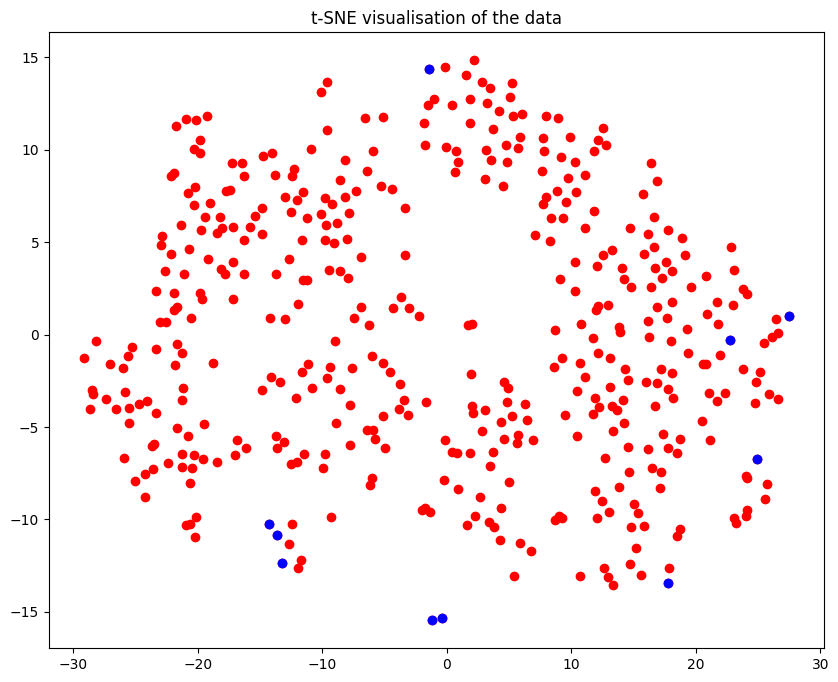

In [4]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(df_log)
top_anomalies = np.argsort(anomaly_scores)[-10:]

plt.figure(figsize=(10, 8))
colors = 'r' # Color for normal instances.
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=colors)

# Highlighting the top 10 anomalies.
colors = 'b' # Color for anomalies.
plt.scatter(X_2d[top_anomalies.get(), 0], X_2d[top_anomalies.get(), 1], c=colors)

plt.title('t-SNE visualisation of the data')
plt.show()

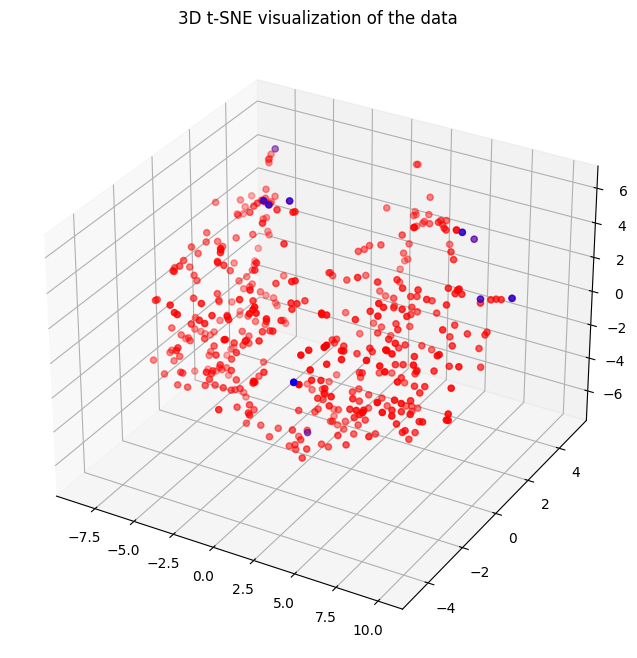

In [6]:
tsne = TSNE(n_components=3, random_state=0)
X_3d = tsne.fit_transform(df_log)
top_anomalies = np.argsort(anomaly_scores)[-10:]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = 'r' # Color for normal instances.
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=colors)

# Highlighting the top 10 anomalies.
colors = 'b' # Color for anomalies.
ax.scatter(X_3d[top_anomalies.get(), 0], X_3d[top_anomalies.get(), 1], X_3d[top_anomalies.get(), 2], c=colors)

plt.title('3D t-SNE visualization of the data')
plt.show()

# 4: Cluster Analysis

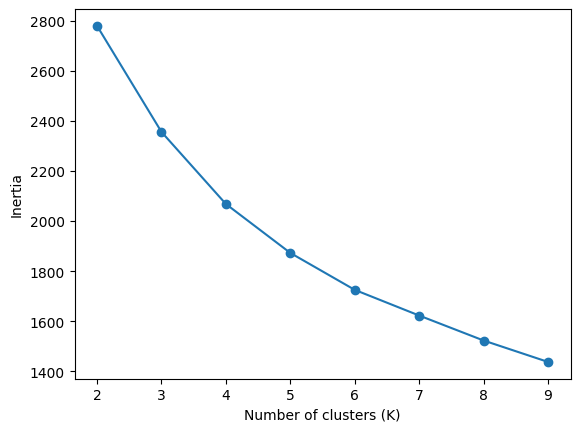

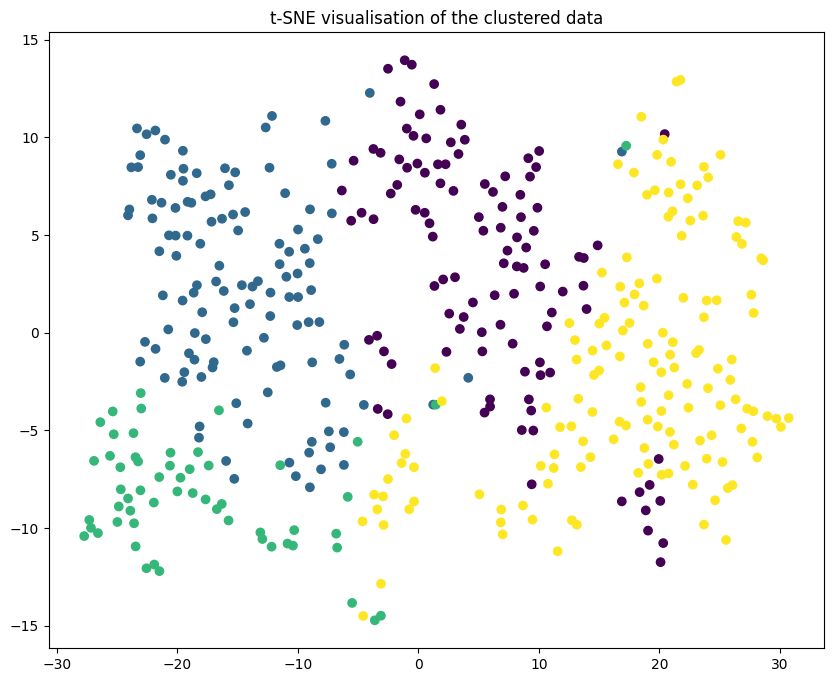

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Convert the CuPy array to a NumPy array for compatibility with pandas
top_anomalies_np = top_anomalies.get()

# Convert the NumPy array to a list
top_anomalies_list = top_anomalies_np.tolist()

# Drop the rows from the dataframe
df_clean = df_log.drop(top_anomalies_list)

# Determine the optimal number of clusters using the elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 10)

for K in K_range:
    kmeans = KMeans(n_clusters=K, max_iter=1000, n_init=1000).fit(df_clean)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_clean, kmeans.labels_))

plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.show()

# Select the optimal number of clusters
K = 4

# Perform k-means clustering
kmeans = KMeans(n_clusters=K, max_iter=1000, n_init=1000).fit(df_clean)

# Assign clusters to data points
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(df_clean)

plt.figure(figsize=(10, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans.fit_predict(df_clean))
plt.title('t-SNE visualisation of the clustered data')
plt.show()

# Compute cluster centroids
centroids = np.exp(kmeans.cluster_centers_) - 1  

**Using k-means clustering we found a number of 4 clusters optimal using the elbow method. The data was plotted again using t-SNE visualisation and coloring according to the clustering. We used the centroids to plot the annual spending behaviour of the customer groups sorted by the different product categories to gain further insight into the clusters.**

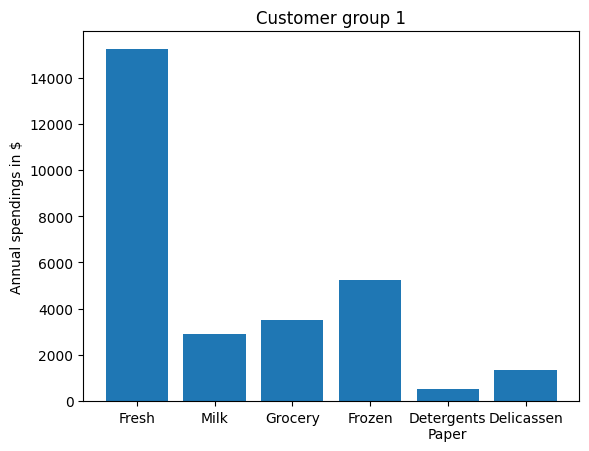

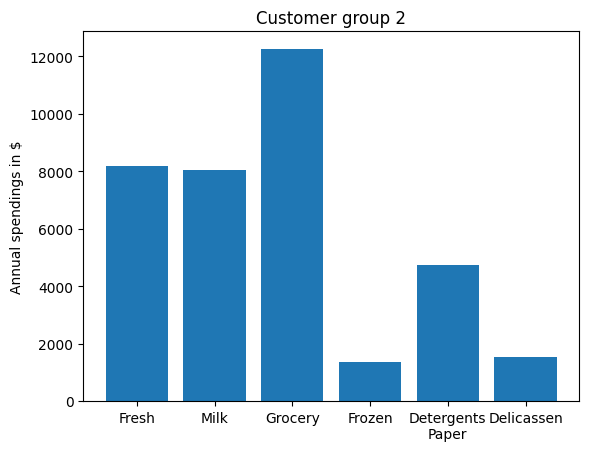

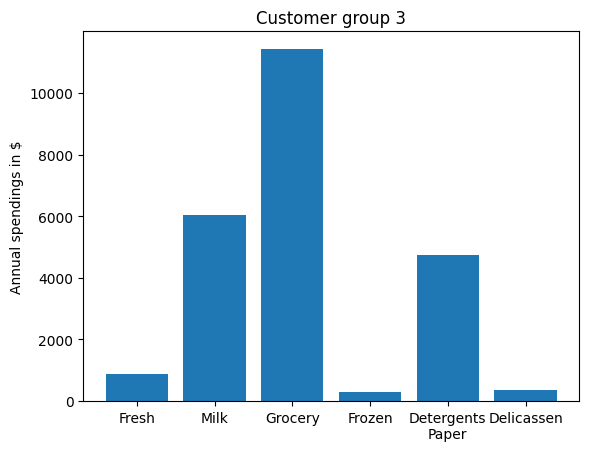

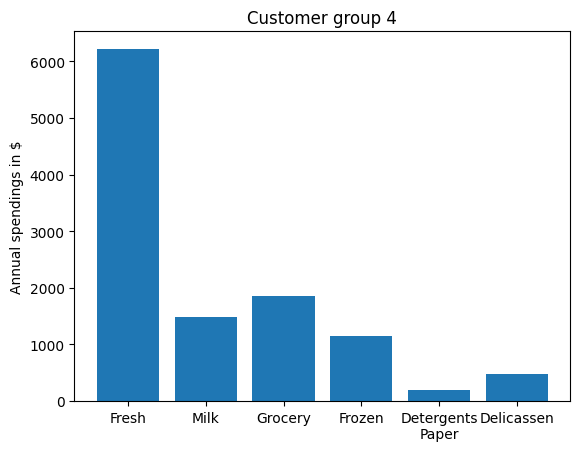

In [9]:
for i in range(len(centroids)):
  plt.bar(["Fresh","Milk","Grocery","Frozen","Detergents\nPaper","Delicassen"],centroids[i])
  plt.ylabel("Annual spendings in $")
  plt.title("Customer group {}".format(i+1))
  plt.show()
